<a href="https://colab.research.google.com/github/PreethamThinagaraj/CE888/blob/main/Lab%204/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [3]:
len(data)

24983

### Dropping column'0' 
As it denotes number of jokes that user have rated so far

In [4]:
data_copy = data.drop(columns=0)
data_copy.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
data_copy = data_copy.replace(99.00,np.NaN)

In [6]:
data_copy.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


### Best and Worst jokes 

In [7]:
a = data_copy.mean(axis=0)

In [8]:
best_joke = a.idxmax()
worst_joke =a.idxmin()

In [9]:
print(best_joke)
print(worst_joke)


50
58


In [10]:
data_copy.iloc[1121,37]

7.28

### Original array

In [11]:
orig_array = data_copy.values

In [12]:
orig_array

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [14]:
orig_array[1050][37]

-8.83

### Validation set 

In [15]:
def replace(orig, percentage=0.1):
  new_data = orig.copy()
  rated = np.where(~np.isnan(orig))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [16]:
validation_array, idx = replace(orig_array, 0.1)

### Latent Factor 

In [17]:
n_latent_factors = 2

user_ratings = data_copy.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [18]:
latent_user_preferences.shape

(24983, 2)

In [19]:
latent_item_features.shape

(100, 2)

In [20]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating) and rating < 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [21]:
num_iter = 100
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/100:	MSE=26.122341
Iteration 10/100:	MSE=22.940920
Iteration 20/100:	MSE=19.817186
Iteration 30/100:	MSE=17.550652
Iteration 40/100:	MSE=17.243162
Iteration 50/100:	MSE=17.168427
Iteration 60/100:	MSE=17.144502
Iteration 70/100:	MSE=17.136343
Iteration 80/100:	MSE=17.133647
Iteration 90/100:	MSE=17.132966


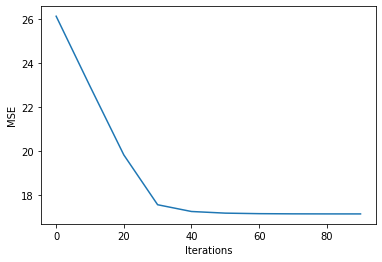

In [22]:
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [23]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[-3.90594069, -4.1622665 , -5.62846486, ..., -2.4602022 ,
        -6.21163955, -2.59275359],
       [ 2.98208867,  3.14367295,  3.78312606, ...,  2.51124442,
         3.95945271,  2.75945953],
       [ 6.86636952,  7.15454998,  7.44689669, ...,  7.33838961,
         7.1917434 ,  8.27136787],
       ...,
       [-0.97683499, -1.03585246, -1.33096504, ..., -0.7096521 ,
        -1.43671193, -0.76472407],
       [-2.11825456, -2.26419233, -3.15680785, ..., -1.20566473,
        -3.52768574, -1.24769247],
       [ 2.79170901,  2.87560099,  2.5263064 , ...,  3.60100562,
         2.16026381,  4.12373517]])

In [25]:
# Calculate the performance of the algorithm on the validation dataset.

validation_error = []
for user in range(len(orig_array)):
  for rating in range(len(orig_array[user])):
    if(not np.isnan(orig_array[user][rating]) and orig_array[user][rating]!=validation_array[user][rating] ):
      predict = predict_rating(user,rating)
      validation_error.append(orig_array[user][rating] - predict)
      #print("Expected: " + str(orig_arrays[user][rating]) + "\tActual: " + str(predict))
print("Validation MSE is ,",(np.array(validation_error) ** 2).mean())

Validation MSE is , 17.034774382599913


In [26]:
# Predict Test Dataset
predictions =[]
for user in range(len(orig_array)):
  score=[]
  for rating in range(len(orig_array[user])):
    predict = predict_rating(user,rating)
    score.append(predict)
  predictions.append(score)


In [38]:
predictions[3599][46]

1.4346338700028343

### PART 2 - with movies dataset

In [36]:
movie_df =pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx',sheet_name="Items")
movie_df.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [37]:
users_df =pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx',sheet_name="Users")
users_df

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357


In [ ]:
pred = np.array(items_df.iloc[:,2:17]).dot(np.array(users_df.iloc[:,1:16].T))
pred.shape

(100, 25)

In [ ]:
users_df['User'].values

array([4768,  156, 5323,  174, 4529,  783, 3878,  768, 4469, 1882, 4997,
       2067, 3806, 2848, 4433, 3519, 5338, 3947, 4373, 2092,  525, 4327,
       3048, 2665, 4940])

In [ ]:
users_df[users_df['User'] == 4469]

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.01995,-0.014435,0.010926,0.0244,0.005318,-0.007983


In [39]:
movie_df[movie_df['Movie ID'] == 550]['Factor13']

41    1.170795
Name: Factor13, dtype: float64

In [40]:
movie_df[movie_df['Title'] == 'Pretty Woman (1990)']['Factor10']

13    0.378786
Name: Factor10, dtype: float64

In [42]:
movie_df[movie_df['Title'] == 'Almost Famous (2000)']['Factor10']

62    0.267137
Name: Factor10, dtype: float64

In [43]:
movie_df[movie_df['Title'] == 'Mission: Impossible II (2000)']['Factor10']

72    0.162099
Name: Factor10, dtype: float64

In [44]:
movie_df[movie_df['Title'] == 'True Lies (1994)']['Factor10']

99    0.934767
Name: Factor10, dtype: float64

In [45]:
movie_df[movie_df['Title'] == 'Titanic (1997)']['Factor10']

47   -2.986807
Name: Factor10, dtype: float64

In [ ]:
def predict_movie_ratimg(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferencess[user_id]
    item_preference = latent_item_featuress[item_id]
    return user_preference.dot(item_preference)

In [ ]:
latent_user_preferencess =  np.array(items_df)
latent_item_featuress =np.array(users_df)

In [50]:
def predict_movie_rating(user_id,movie_id):
  a=movie_df[movie_df["Movie ID"] == movie_id]
  b=users_df[users_df["User"] == user_id]
  x=np.array(a.iloc[:,2:17])
  y =np.array(b.iloc[:,1:16]) 
  output = x.dot(y.T)
  return output

In [51]:
predict_movie_rating(4433,11)

array([[-0.41517592]])

In [52]:
predict_movie_rating(1882,161)

array([[0.26777443]])

In [53]:
predict_movie_rating(2665,66)

array([], shape=(0, 1), dtype=float64)

In [54]:
predict_movie_rating(2665,38)

array([[-0.07971887]])

In [55]:
predict_movie_rating(2665,99)

array([], shape=(0, 1), dtype=float64)

In [56]:
predict_movie_rating(2665,13)

array([[0.23432597]])

In [57]:
predict_movie_rating(2665,2501)

array([[0.61823663]])

In [58]:
predict_movie_rating(2665,604)

array([[0.70771849]])

In [59]:
def predict_movie_rating_title(user_id,title):
  a=movie_df[movie_df["Title"] == title]
  b=users_df[users_df["User"] == user_id]
  x=np.array(a.iloc[:,2:17])
  y =np.array(b.iloc[:,1:16]) 
  output = x.dot(y.T)
  return output

In [72]:
predict_movie_rating_title(4469,'Pretty Woman (1990)')

array([[0.01093566]])

In [73]:
predict_movie_rating_title(4469,'The Shawshank Redemption (1994)')

array([[0.20767971]])

In [74]:
predict_movie_rating_title(4469,'Star Wars: Episode VI - Return of the Jedi (1983)')

array([[0.020453]])

In [75]:
predict_movie_rating_title(4469,'Gladiator (2000)')

array([[0.17361148]])

In [76]:
predict_movie_rating_title(4469,'The Lord of the Rings: The Fellowship of the Ring (2001)')

array([[0.02189263]])

In [77]:
predict_movie_rating_title(4469,'Toy Story (1995)')

array([[-0.10116581]])

In [78]:
predict_movie_rating_title(4469,'A Beautiful Mind (2001)')

array([[0.18328561]])